# Demo Overview
 

 
In this demo, we will walk through basic real-time deployment capabilities in Databricks. Model Serving allows us to deploy models and query it using various methods.
 

In this demo, we'll discuss this in the following steps:
 
1. Prepare a model to be deployed.
 
2. Deploy the registered model to a Databricks Model Serving endpoint.
 
3. Query the endpoint using various methods such as python sdk and mlflow deployments.
 
 


# Model Preparation
 
When we do this, we need to first to create our model.
 
We have already created a RAG model as a part of the set up of this lesson and have logged it in Unity Catalog for governance purposes and ease of deployment to Model Serving.

In [ ]:
import mlflow
from mlflow import MlflowClient

# Construct model name correctly without extra space
model_name = f"{DA.catalog_name}.{DA.schema_name}.rag_app"

# Point to Unity Catalog registry
mlflow.set_registry_uri("databricks-uc")

def get_latest_model_version(model_name_in: str = None) -> str:
    '''
    Get latest version of registered model
    '''
    client = MlflowClient()
    
    model_version_infos = client.search_model_versions(f"name = '{model_name_in}'")
    
    if model_version_infos:
        return max([model_version_info.version for model_version_info in model_version_infos])
    else:
        return None


In [ ]:
latest_model_version = get_latest_model_version(model_name)

if latest_model_version:
    print(f"Model created and logged to: {model_name}/{latest_model_version}")
else:
    raise BaseException("Error: Model not created, verify if 00-Build-Model script ran successfully!")


In [1]:
pip install matplotlib


  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl (223 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ------------------ --------------------- 1.0/2.2 MB 4.6 MB/s eta 0:00:01
   ------------------------------------- -- 2.1/2.2 MB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 5.0 MB/s eta 0:00:00
Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl (71 kB)
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---- ----------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


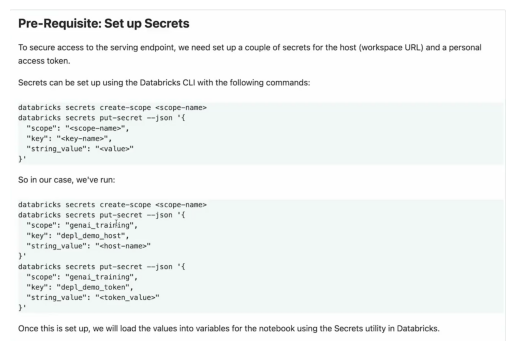

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("Screenshot 2025-07-08 162318.png")
plt.imshow(img)
plt.axis('off')  # hides axis
plt.show()


# Deploy model using databricks-sdk API
 
In the notebook we will use the API to create the endpoint and serving the model.
 
Note: You could also simply use the Ul for this task.
 
Expected deployment time: ~10 mins

In [ ]:
from databricks.sdk.service.serving import EndpointCoreConfigInput

# Configure the endpoint
endpoint_config_dict = {
    "served_models": [
        {
            "model_name": model_name,
            "model_version": latest_model_version,
            "scale_to_zero_enabled": True,
            "workload_size": "Small",
            "environment_vars": {
                "DATABRICKS_TOKEN": "{{secrets/genai_training/depl_demo_token}}",
                "DATABRICKS_HOST": "{{secrets/genai_training/depl_demo_host}}"
            },
            "auto_capture_config": {
                "catalog_name": DA.catalog_name,
                "schema_name": DA.schema_name,
                "table_name_prefix": "rag_app_realtime"
            }
        }
    ]
}

# Create EndpointCoreConfigInput object from dictionary
endpoint_config = EndpointCoreConfigInput.from_dict(endpoint_config_dict)


In [ ]:
from databricks.sdk import WorkspaceClient

# Initiate the workspace client
w = WorkspaceClient()

serving_endpoint_name = f"{DA.unique_name('_')}_endpoint"

# Get endpoint if it exists
existing_endpoint = next(
    (e for e in w.serving_endpoints.list() if e.name == serving_endpoint_name), None
)

# Get Databricks host from notebook context
db_host = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().get("browserHostName").value()

serving_endpoint_url = f"{db_host}/ml/endpoints/{serving_endpoint_name}"

# If endpoint doesn't exist, create it
if existing_endpoint is None:
    print(f"Creating the endpoint {serving_endpoint_url}, this will take a few minutes to package and deploy the endpoint...")
    w.serving_endpoints.create_and_wait(name=serving_endpoint_name, config=endpoint_config)

# If endpoint does exist, update it to serve the new version
else:
    print(f"Updating the endpoint {serving_endpoint_url} to version {latest_model_version}, this will take a few minutes to package and deploy the endpoint...")
    w.serving_endpoints.update_config_and_wait(
        name=serving_endpoint_name,
        served_models=endpoint_config.served_models
    )

# Show clickable link to the endpoint
displayHTML(
    f'Your Model Endpoint is now available. Open the '
    f'<a href="/ml/endpoints/{serving_endpoint_name}" target="_blank">'
    f'Model Serving Endpoint page</a> for more details.'
)


Perform Inference on the Model
 
Next, we will want to perform inference using the model - that is, provide input and return output.
 
We'll start with a simple example of a single input:

In [ ]:
question="what is PPO"

# INFERENCE WITH SDK

In [ ]:
answer = w.serving_endpoints.query(serving_endpoint_name, inputs=[{"query": question}])

print(answer.predictions)


# inference with MLflow deployment

In [ ]:
from mlflow.deployments import get_deploy_client

deploy_client = get_deploy_client("databricks")

response = deploy_client.predict(
    endpoint=serving_endpoint_name,
    inputs={"inputs": [{"query": question}]}
)

print(response.predictions)


# Demo Overview
 
In this demonstration, we will be introducing Lakehouse Monitoring for GenAl applications.
 
To complete this demo, we'll follow the below steps:
 
1. Unpack the Inference Table for an existing Model Serving Endpoint.
 
2. Compute some LLM metrics.
 
3. Describe the basics of using Lakehouse Monitoring.
 
4. Set up a more robust monitor using Lakehouse Monitoring

# Step1: Create Inference Table
 
To demonstrate monitoring, we will create a pre-populated sample inference table. The inference table is already created for you in the course config notebook.

In [ ]:
from delta.tables import DeltaTable

inference_table_name = f"{DA.catalog_name}.{DA.schema_name}.rag_app_realtime_payload"

# Check whether the table exists before proceeding
if spark._jsparkSession.catalog().tableExists(inference_table_name):
    display(spark.sql(f"SELECT * FROM {inference_table_name} LIMIT 5"))
else:
    raise Exception("Inference table does not exist, please re-run or verify the classroom setup script.")


# 2.1: Unpacking the table
 
The request and response columns contains model prompts and output as a string.
 
Note: the format depends on model definition but inputs are usually represented as JSON with TF format, and the output depends on model definition as well.
 
We will use Spark JSON Path annotation to directly access the prompt and completions as string, concatenate them together with an array_zip and finally explode the content to have single prompt/completions rows.
 
Note: This will be made easier within the product directly--we provide this notebook to simplify this task for now.

In [ ]:
# The format of the input payloads, following the TF "inputs" serving format with a "query" field.

# Single query input format: {"inputs": [{"query": "User question?"}]}
INPUT_REQUEST_JSON_PATH = "inputs[*].query"

# Matches the schema returned by the JSON selector (inputs[*].query is an array of strings)
INPUT_JSON_PATH_TYPE = "array<string>"

KEEP_LAST_QUESTION_ONLY = False

# Answer format: {"predictions": ["answer"]}
OUTPUT_REQUEST_JSON_PATH = "predictions"

# Matches the schema returned by the JSON selector (predictions is an array of strings)
OUTPUT_JSON_PATH_TYPE = "array<string>"


Now test the unpacking on a simple in more batch mode

In [ ]:
payloads_sample_df = spark.table(inference_table_name).where('status_code = 200').limit(18)

payloads_unpacked_sample_df = unpack_requests(
    payloads_sample_df,
    INPUT_REQUEST_JSON_PATH,
    INPUT_JSON_PATH_TYPE,
    OUTPUT_REQUEST_JSON_PATH,
    OUTPUT_JSON_PATH_TYPE,
    KEEP_LAST_QUESTION_ONLY
)

display(payloads_unpacked_sample_df)


2.2: Compute [Prompt-Completion] Evaluation Metrics
 
Let's compute some text evaluation metrics such as toxicity, perplexity and readability.
 
These will be analyzed by Lakehouse Monitoring so that we can understand how these metrics change over time.
 
Note: This is a non-exhaustive list and these calculations will be automatically performed out-of-the-box within the product --we provide this notebook to simplify this task for now.

In [ ]:
import tiktoken, textstat, evaluate
import pandas as pd
from pyspark.sql.functions import pandas_udf

@pandas_udf("int")
def compute_num_tokens(texts: pd.Series) -> pd.Series:
    encoding = tiktoken.get_encoding("cl100k_base")
    return pd.Series(map(len, encoding.encode_batch(texts)))

@pandas_udf("double")
def flesch_kincaid_grade(texts: pd.Series) -> pd.Series:
    return pd.Series([textstat.flesch_kincaid_grade(text) for text in texts])

@pandas_udf("double")
def automated_readability_index(texts: pd.Series) -> pd.Series:
    return pd.Series([textstat.automated_readability_index(text) for text in texts])

@pandas_udf("double")
def compute_toxicity(texts: pd.Series) -> pd.Series:
    # Omit entries with null input from evaluation
    toxicity = evaluate.load("toxicity", module_type="measurement", cache_dir="/tmp/hf_cache/")
    return pd.Series(toxicity.compute(predictions=texts.fillna(""))["toxicity"]).where(texts.notna(), None)

@pandas_udf("double")
def compute_perplexity(texts: pd.Series) -> pd.Series:
    # Omit entries with null input from evaluation
    perplexity = evaluate.load("perplexity", module_type="measurement", cache_dir="/tmp/hf_cache/")
    return pd.Series(perplexity.compute(data=texts.fillna(""), model_id="gpt2")["perplexities"]).where(texts.notna(), None)


In [ ]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col

def compute_metrics(requests_df: DataFrame, column_to_measure: list = ["input", "output"]) -> DataFrame:
    for column_name in column_to_measure:
        requests_df = (
            requests_df.withColumn(f"toxicity({column_name})", compute_toxicity(col(column_name)))
                       .withColumn(f"perplexity({column_name})", compute_perplexity(col(column_name)))
                       .withColumn(f"token_count({column_name})", compute_num_tokens(col(column_name)))
                       .withColumn(f"flesch_kincaid_grade({column_name})", flesch_kincaid_grade(col(column_name)))
                       .withColumn(f"automated_readability_index({column_name})", automated_readability_index(col(column_name)))
        )
    return requests_df


In [ ]:
import os

# Reset checkpoint (for demo purposes ONLY)
checkpoint_location = os.path.join(DA.paths.working_dir, "checkpoint")
dbutils.fs.rm(checkpoint_location, True)

# Unpack the requests as a stream
requests_raw_df = spark.readStream.table(inference_table_name)

requests_processed_df = unpack_requests(
    requests_raw_df,
    INPUT_REQUEST_JSON_PATH,
    INPUT_JSON_PATH_TYPE,
    OUTPUT_REQUEST_JSON_PATH,
    OUTPUT_JSON_PATH_TYPE,
    KEEP_LAST_QUESTION_ONLY
)

# Drop unnecessary columns for monitoring jobs
requests_processed_df = requests_processed_df.drop(
    "date", "status_code", "sampling_fraction", "client_request_id", "databricks_request_id"
)

# Compute text evaluation metrics
requests_with_metrics_df = compute_metrics(requests_processed_df)


In [ ]:
from delta.tables import DeltaTable

def create_processed_table_if_not_exists(table_name: str, requests_with_metrics):
    """
    Helper method to create a Delta table using the schema of the given DataFrame,
    with change data feed (CDF) and column mapping enabled.
    """
    if not spark._jsparkSession.catalog().tableExists(table_name):
        # Write empty DataFrame with schema to create the table
        (
            requests_with_metrics.limit(0)
            .write
            .format("delta")
            .option("delta.enableChangeDataFeed", "true")
            .option("delta.columnMapping.mode", "name")
            .saveAsTable(table_name)
        )


In [ ]:
from delta.tables import DeltaTable

def create_processed_table_if_not_exists(table_name: str, requests_with_metrics):
    """
    Helper method to create a Delta table using the schema of the given DataFrame,
    with change data feed (CDF) and column mapping enabled.
    """
    if not spark._jsparkSession.catalog().tableExists(table_name):
        # Write empty DataFrame with schema to create the table
        (
            requests_with_metrics.limit(0)
            .write
            .format("delta")
            .option("delta.enableChangeDataFeed", "true")
            .option("delta.columnMapping.mode", "name")
            .saveAsTable(table_name)
        )


In [ ]:
# Persist the requests stream, with a defined checkpoint path for this table

processed_table_name = f"{DA.catalog_name}.{DA.schema_name}.rag_app_processed_inferences"

# Create the table if it doesn't exist
create_processed_table_if_not_exists(processed_table_name, requests_with_metrics_df)

# Append new unpacked payloads & metrics
(
    requests_with_metrics_df.writeStream
    .trigger(availableNow=True)
    .format("delta")
    .outputMode("append")
    .option("checkpointLocation", checkpoint_location)  # corrected key name
    .toTable(processed_table_name)
    .awaitTermination()
)

# Display the table (with requests and text evaluation metrics) that will be monitored
display(spark.table(processed_table_name))


# step 3 describe the basic of lakehouse monitering

# 4.2 using the databricks sdk

In [ ]:
from databricks.sdk import WorkspaceClient
from databricks.sdk.service.catalog import MonitorTimeSeries
import os

# Create monitor using databricks-sdk's 'quality_monitors' client
w = WorkspaceClient()

try:
    lhm_monitor = w.quality_monitors.create(
        table_name=processed_table_name,  # Always use 3-level namespace
        time_series=MonitorTimeSeries(
            timestamp_col="timestamp",
            granularities=["5 minutes"]
        ),
        assets_dir=os.getcwd(),
        slicing_exprs=["model_id"],
        output_schema_name=f"{DA.catalog_name}.{DA.schema_name}"
    )
except Exception as lhm_exception:
    print(lhm_exception)


In [ ]:
from databricks.sdk.service.catalog import MonitorInfoStatus

# Get monitor info
monitor_info = w.quality_monitors.get(processed_table_name)

# Print monitor status
print(monitor_info.status)

# Suggest next action if it's still creating
if monitor_info.status == MonitorInfoStatus.MONITOR_STATUS_PENDING:
    print("Wait until monitor creation is completed...")


In [ ]:
monitor_info = w.quality_monitors.get(processed_table_name)

assert monitor_info.status == MonitorInfoStatus.MONITOR_STATUS_ACTIVE, \
    "Monitoring is not ready yet. Check back in a few minutes or view the monitoring creation process for any errors."
